In [3]:
# EXECUTE FIRST

# computational imports
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
#nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet as wn
import string

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from scipy.spatial import distance

# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

<p><font size=18>Week 13: Recommender Systems 1</font></p>

Recommender Systems are a complicated topic. This week's lesson and next week's lesson are intended to just give you a small taste of what recommender systems can do. To truly implement a recommender system, you'd want to dive much deeper. It's a topic worthy of more study. Recommender systems are all around you. Let's explore one recommender system you're probably familiar with, Netflix. 

<iframe width="560" height="315" src="https://www.youtube.com/embed/L0qVVRJoCf0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

This week we'll look at two types of recommenders: Knowledge-Based Recommenders and Content-Based Recommenders. These systems are both used to address the "cold-start" problem. The cold-start problem is the idea that when you first launch a recommender site, you probably don't have data about what a user likes or how your items have been rated by other users. This lack of data makes it difficult to return really good recommendations, as most of the best recommenders rely on having ratings data. It also makes it impossible to quantify the quality of your recommendations. If you were building recommenders like this in real life, you might want to do some user-testing to validate if your recommender system is making good suggestions. Here, we'll just rely on our own best judgement.

# Knowledge-Based Recommender

The knowledge-based recommender is just a simple ranked chart of data built using some input from the user. Banik describes it as a recommender that:
1. Gets user input on their preferences.
2. Extracts all the records that match the conditions set by the user.
3. Calculates a score to sort the records.
4. Returns the sorted results.


## The Data
Like most data science projects, preparing/wrangling/cleaning your data for your recommender system can be the hardest part. In the lessons and homework, we'll be providing you data that has already been simplified to some extent, so we can focus more on the concepts of recommender systems. For our knowledge-based recommender, we're going to be using the movies_metadata_clean.csv file in the data directory of the lesson. If you'd like to see how we got to this file from the movies_metadata.csv file used in the book, please review the "DataCleaning" notebook in the extras directory.

In [4]:
#read in the file
df = pd.read_csv('data/movies_metadata_clean.csv')
print(f'The shape of the dataframe is {df.shape}')
df.head()

The shape of the dataframe is (5000, 10)


,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year
0,862,Toy Story,30000000.0,"['Animation', 'Comedy', 'Family']","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995
1,8844,Jumanji,65000000.0,"['Adventure', 'Fantasy', 'Family']",When siblings Judy and Peter discover an encha...,262797249,104.0,6.9,2413,1995
2,15602,Grumpier Old Men,0.0,"['Romance', 'Comedy']",A family wedding reignites the ancient feud be...,0,101.0,6.5,92,1995
3,31357,Waiting to Exhale,16000000.0,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",81452156,127.0,6.1,34,1995
4,11862,Father of the Bride Part II,0.0,['Comedy'],Just when George Banks has recovered from his ...,76578911,106.0,5.7,173,1995


We can see that genres looks like a list. To get Python to treat it like a list, we'll need to apply literal_eval

In [5]:
# Convince Python that this column should be treated like a list, not a string.
df['genres'] = df['genres'].apply(literal_eval)

### Avoiding "Explode"
Banik would have you "explode" the genres. He does this to make it easier to filter on the genres column, but it has an unfortunate side effect of making duplicate rows per movie. It's easy to avoid that by using a different method of filtering. Let's see how that works.

In [6]:
#let's fetch just the first 5 rows of our dataframe
snip = df[:5]
print('The first 5 movies are:')
display(snip)

#let's create a filter that will be True if "Family" is in the list of genres for each movie
hasFamilyFilter = snip['genres'].apply(lambda x: "Family" in x)
print(f'Family filter values \n {hasFamilyFilter}')

#let's create a filter that will be True if "Drama" is in the list of genres of each movie
hasDramaFilter = snip['genres'].apply(lambda x: "Drama" in x)
print(f'Drama filter values \n{hasDramaFilter}')

#let's filter our dataset to just those movies that have Family OR Drama. Note the placement of the parenthesis
print('These movies have drama OR family.')
display(snip[(hasFamilyFilter) | (hasDramaFilter)])

#let's filter our dataset to just those movies that have Comedy AND Romance OR have a vote_count > 5000.
#let's use variables for our two genres
selected1 = 'Romance'
selected2 = 'Comedy'

#instead of creating stand-alone filters, we'll filter "on the fly" using the apply right in the filter
#again, pay attention to where the parentheses go
print('These movies have (Romance and Comedy) OR more than 5000 votes.')
snip[(snip['vote_count'] > 5000) | 
     ((snip['genres'].apply(lambda x: selected1 in x)) & 
      (snip['genres'].apply(lambda x: selected2 in x)))]


The first 5 movies are:


,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995
1,8844,Jumanji,65000000.0,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,262797249,104.0,6.9,2413,1995
2,15602,Grumpier Old Men,0.0,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,0,101.0,6.5,92,1995
3,31357,Waiting to Exhale,16000000.0,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",81452156,127.0,6.1,34,1995
4,11862,Father of the Bride Part II,0.0,[Comedy],Just when George Banks has recovered from his ...,76578911,106.0,5.7,173,1995


Family filter values 
 0     True
1     True
2    False
3    False
4    False
Name: genres, dtype: bool
Drama filter values 
0    False
1    False
2    False
3     True
4    False
Name: genres, dtype: bool
These movies have drama OR family.


,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995
1,8844,Jumanji,65000000.0,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,262797249,104.0,6.9,2413,1995
3,31357,Waiting to Exhale,16000000.0,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",81452156,127.0,6.1,34,1995


These movies have (Romance and Comedy) OR more than 5000 votes.


,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995
2,15602,Grumpier Old Men,0.0,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,0,101.0,6.5,92,1995
3,31357,Waiting to Exhale,16000000.0,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",81452156,127.0,6.1,34,1995


### Fetching unique values from a column of lists
The one other thing we need to be able to do where the exploding helps is to get the list of unique genres. Let's look at how we could do that. We'll do it slightly differently than Banik. And, we'll first break it down into steps so you can see what's happening.

In [7]:
#in steps
#convert the genres list in a series of columns
step1 = snip.apply(lambda x:pd.Series(x['genres']),axis=1)
print(f"Step 1\n{step1}")

#this step converts the rows into columns and "stacks" them all together
step2 = step1.stack()
print(f"Step 2\n{step2}")

#let's get just the unique values from this series
step3 = step2.unique()
print(f"Step 3\n{step3}")
print(f"Step 3 is a \n{type(step3)}")

#numpy arrays can be joined just like lists, so let's join it to create a comma-delimited string
step4 = ', '.join(step3)
print(f"Step 4\n{step4}")

#let's do it all in one step
allGenres = ', '.join(snip.apply(lambda x:pd.Series(x['genres']),axis=1).stack().unique())
allGenres

Step 1
           0        1        2
0  Animation   Comedy   Family
1  Adventure  Fantasy   Family
2    Romance   Comedy      NaN
3     Comedy    Drama  Romance
4     Comedy      NaN      NaN
Step 2
0  0    Animation
   1       Comedy
   2       Family
1  0    Adventure
   1      Fantasy
   2       Family
2  0      Romance
   1       Comedy
3  0       Comedy
   1        Drama
   2      Romance
4  0       Comedy
dtype: object
Step 3
['Animation' 'Comedy' 'Family' 'Adventure' 'Fantasy' 'Romance' 'Drama']
Step 3 is a 
<class 'numpy.ndarray'>
Step 4
Animation, Comedy, Family, Adventure, Fantasy, Romance, Drama


'Animation, Comedy, Family, Adventure, Fantasy, Romance, Drama'

### *Self-Assessment: Modularize Fetching Unique Items*

Getting a unique list of items from a Pandas column that contains lists is exactly the kind of thing you might have to do fairly often. Even though Pandas makes this fairly easy, let's modularize the code. Write a function that takes in a dataframe, the name of the column from which to pull unique lists, a type parameter to determine if you should return a numpy array or a string, and a True/False sort parameter to determine if the <a href="https://numpy.org/doc/stable/reference/generated/numpy.sort.html">returned list should be sorted</a>. Use the provided code below to get you started.

In [8]:
#this is a test dataframe to use
sa1_df = pd.DataFrame({
        'Food': ['Cake', 'Pie', 'Ice Cream'],
        'Flavors': [['Chocolate','Vanilla', 'Marble'], ['Apple', 'Chocolate', 'Cherry'], ['Vanilla', 'Cherry', 'Mint']]
    })
display(sa1_df)

#note that Python already thinks we have lists in the flavor column, so we don't need literal_eval
print(f"Each flavor cell is already of type {type(sa1_df['Flavors'][0])}")

,Food,Flavors
0,Cake,"[Chocolate, Vanilla, Marble]"
1,Pie,"[Apple, Chocolate, Cherry]"
2,Ice Cream,"[Vanilla, Cherry, Mint]"


Each flavor cell is already of type <class 'list'>


In [9]:
def getUniqueListFromColumn(df, col, returntype = 'string', sort=True):
    #enter your code here
    

#This line calls your code. Try it with array instead of string, or not sorted, too
getUniqueListFromColumn(sa1_df, 'Flavors', 'string', True)

IndentationError: expected an indented block (1715688343.py, line 6)

## Creating a metric
Knowledge-based recommenders rely on some sort of score for returning their results. There's no right answer for what the score is or how it should be calculated. You'll need to consider the data that you're working with and decide how to calculate a meaningful score. If you are running an e-commerce site, you might use products with the highest percent off sale. If you're recommending library books, you might use a score built off of the number of times the book has been checked out, weighted by the number of weeks since it was first in circulation.

For this example, we're interested in highly-rated movies. But, it makes sense to consider both the average rating for a movie and the number of people that rated the movie. Say you have a rating scale from 1 to 5 stars. Your highest average rating would be 5 - a perfect score. But does a rating of 5 by one user mean the same thing as a rating of 5 by 100 users? Probably not.

Banik solves this problem by using the IMDB weighted rating. 

$$Weighted Rating (WR) = \left(\frac{v}{v+m} * R\right) + \left(\frac{m}{v+m}*C\right)$$
 
Where:
* v is the number of votes garnered by the movie
* m is the minimum number of votes required for the movie to be in the chart (the prerequisite)
* R is the mean rating of the movie
* C is the mean rating of all the movies in the dataset

Banik chose the 80th percentile for the minimum number of votes to be included in the recommender. 

Note that Banik chooses m (our minimum number of votes) based on the whole dataset, because IMDB sets this as the minimum threshold for being included in the ratings. So m is both a part of the metric AND a filter.

Let's also base C on the whole dataset to start.

Let's fetch C and m and filter to movies that have vote_counts greater than or equal to the 80th quantile. (This is equivalent to getting the top 20% of votes.) 

In [10]:
#fetch C from the whole dataset
C = df['vote_average'].mean()
print(f"C is {C}")

#fetch m from the whole dataset
m = df['vote_count'].quantile(.8)
print(f"m is {m}")

#filter to movies that have greater than or equal to 80% of the votes
df = df[df['vote_count'] >= m]

#see how many movies are left.
df.shape

C is 6.06916
m is 255.20000000000027


(1000, 10)

Let's write our function to do scoring. Note that unlike Banik's metric, our version takes in x (the row of data) and m & C. Passing all the variables you need into the the function is a best practice that Banik does not follow, but we do.

In [11]:
def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    # Compute the weighted score
    return (v/(v+m) * R) + (m/(m+v) * C)

Let's apply the score to the unfiltered dataframe.

In [12]:
df['score1'] = df.apply(weighted_rating, args=(m,C), axis=1)
df.head()

,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year,score1
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995,7.626600
1,8844,Jumanji,65000000.0,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,262797249,104.0,6.9,2413,1995,6.820534
5,949,Heat,60000000.0,"[Action, Crime, Drama, Thriller]","Obsessive master thief, Neil McCauley leads a ...",187436818,170.0,7.7,1886,1995,7.505628
9,710,GoldenEye,58000000.0,"[Adventure, Action, Thriller]",James Bond must unmask the mysterious head of ...,352194034,130.0,6.6,1194,1995,6.506521
12,21032,Balto,0.0,"[Family, Animation, Adventure]",An outcast half-wolf risks his life to prevent...,11348324,78.0,7.1,423,1995,6.712105


What happens if use C from just the filtered dataframe?

In [13]:
#fetch c from the already filtered data
C2 = df['vote_average'].mean()
print(f"C is {C2}")

df['score2'] = df.apply(weighted_rating, args=(m,C2), axis=1)
df.head()

C is 6.8055


,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year,score1,score2
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995,7.626600,7.659741
1,8844,Jumanji,65000000.0,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,262797249,104.0,6.9,2413,1995,6.820534,6.890962
5,949,Heat,60000000.0,"[Action, Crime, Drama, Thriller]","Obsessive master thief, Neil McCauley leads a ...",187436818,170.0,7.7,1886,1995,7.505628,7.593389
9,710,GoldenEye,58000000.0,"[Adventure, Action, Thriller]",James Bond must unmask the mysterious head of ...,352194034,130.0,6.6,1194,1995,6.506521,6.636188
12,21032,Balto,0.0,"[Family, Animation, Adventure]",An outcast half-wolf risks his life to prevent...,11348324,78.0,7.1,423,1995,6.712105,6.989183


You can see that it does indeed make a difference in the score. But would it make a difference in our recommendations?

### *Self-Assessment: Load and Display*

Load the data set **ted_clean.csv** and display the first 5 rows. This data set can be found in the data folder for this lesson.  More information about this data set <a href = https://www.kaggle.com/rounakbanik/ted-talks> here </a>.  

In [14]:
# enter your code here

### *Self-Assessment: Pandas*

How many talks are in the TED Talks data frame?

### *Self-Assessment: Prerequisites*

Select TED talks with these prerequisites:

1. talks with duration of at least 5 minutes (i.e. 300 seconds)
2. talks with only 1 speaker
3. talks in the top 90\% of views (exclude the bottom 10\%)

Also inspect the number of talks that made the cut.

In [15]:
# enter your code here

### *Self-Assessment: Compute a Metric, Sort and Print*

In the absence of numerical ratings here, use the ratio of the number of comments per 1000 views as a metric to sort the TED talks and print the 10 with the highest ratios.  

Display only the description, the main speaker, and the number of views.

In [16]:
# enter your code here

## Getting User Input
Now that we've seen the pieces of the knowledge-based recommender, all we need to do is wrap the pieces in a function that accepts user input.

Our function will take in a cleaned dataframe and a percentile to use for m. By default, the percentile will be .8. 

Note that the only changes we're making here from Banik's metric is to adjust how we do the genres filter. We'll follow Banik's lead by calculated m after we filter the data to the user's selections.

In [18]:
def build_chart(gen_df, percentile=0.8):
    
    #Ask for preferred genres
    print("Input preferred genre")
    genre = input()
    
    #Ask for lower limit of duration
    print("Input shortest duration")
    low_time = int(input())
    
    #Ask for upper limit of duration
    print("Input longest duration")
    high_time = int(input())
    
    #Ask for lower limit of timeline
    print("Input earliest year")
    low_year = int(input())
    
    #Ask for upper limit of timeline
    print("Input latest year")
    high_year = int(input())
    
    #Define a new movies variable to store the preferred movies. Copy the contents of gen_df to movies
    movies = gen_df.copy()
    
    #Filter based on the condition
    movies = movies[(movies['genres'].apply(lambda x: genre in x)) & #updated filtering based on a list.
                    (movies['runtime'] >= low_time) & 
                    (movies['runtime'] <= high_time) & 
                    (movies['year'] >= low_year) & 
                    (movies['year'] <= high_year)]
    
    #Compute the values of C and m for the filtered movies
    C = movies['vote_average'].mean()
    m = movies['vote_count'].quantile(percentile)
    
    #Only consider movies that have higher than m votes. Save this in a new dataframe q_movies
    q_movies = movies.copy().loc[movies['vote_count'] >= m]
    
    #Calculate score using the IMDB formula
    q_movies['score'] = q_movies.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) 
                                       + (m/(m+x['vote_count']) * C)
                                       ,axis=1)

    #Sort movies in descending order of their scores
    q_movies = q_movies.sort_values('score', ascending=False)
    
    return q_movies

We'll test our code by requesting movies that have the genres 'Family' and a runtime between 80 and 120 minutes and a year between 1980 and 2000. We'll return the output to a variable so we can review it in different ways. (Don't worry if your saved code has extra boxes or looks out of order. That's just a bug in CoCalc's output saving.)

In [23]:
out_movies = build_chart(df, .8)

Input preferred genre


 Family

Input shortest duration


Input longest duration


Input earliest year


 1980

Input latest year


 2000

We have two other versions of scores in the dataset. Let's compare the rankings if we sort in different ways.

In [0]:
#set the score rank column
out_movies['scoreRank'] = np.arange(len(out_movies))
#sort by score1 and set the score1rank column
out_movies = out_movies.sort_values('score1', ascending=False)
out_movies['score1Rank'] = np.arange(len(out_movies))
#sort by score2 and set the score2rank column
out_movies = out_movies.sort_values('score2', ascending=False)
out_movies['score2Rank'] = np.arange(len(out_movies))
#resort by score
out_movies = out_movies.sort_values('score', ascending=False)

#display the final result with just name and scores
out_movies[['title','score1Rank', 'score2Rank', 'scoreRank' ]]

Did the different methods of computing the score impact the recommendation results in a significant way?

### Alternative to prompting for user input

Using `input()` is fine for an application, but if you're just trying to test your recommender system it's easier to pass in the arguments.  Here we've rewritten so that the default inputs are `None` and the user will be prompted for input, but the arguments can be passed to the function to allow for easier testing.

In [24]:
def build_chart(gen_df, percentile=0.8, genre = None, low_time = None, high_time = None, low_year = None, high_year = None):
    
    #Ask for preferred genres
    if genre is None:
        print("Input preferred genre")
        genre = input()
    
    #Ask for lower limit of duration
    if low_time is None:
        print("Input shortest duration")
        low_time = int(input())
    
    #Ask for upper limit of duration
    if high_time is None:
        print("Input longest duration")
        high_time = int(input())
    
    #Ask for lower limit of timeline
    if low_year is None:
        print("Input earliest year")
        low_year = int(input())
    
    #Ask for upper limit of timeline
    if high_year is None:
        print("Input latest year")
        high_year = int(input())
    
    #Define a new movies variable to store the preferred movies. Copy the contents of gen_df to movies
    movies = gen_df.copy()
    
    #Filter based on the condition
    movies = movies[(movies['genres'].apply(lambda x: genre in x)) & #updated filtering based on a list.
                    (movies['runtime'] >= low_time) & 
                    (movies['runtime'] <= high_time) & 
                    (movies['year'] >= low_year) & 
                    (movies['year'] <= high_year)]
    
    #Compute the values of C and m for the filtered movies
    C = movies['vote_average'].mean()
    m = movies['vote_count'].quantile(percentile)
    
    #Only consider movies that have higher than m votes. Save this in a new dataframe q_movies
    q_movies = movies.copy().loc[movies['vote_count'] >= m]
    
    #Calculate score using the IMDB formula
    q_movies['score'] = q_movies.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) 
                                       + (m/(m+x['vote_count']) * C)
                                       ,axis=1)

    #Sort movies in descending order of their scores
    q_movies = q_movies.sort_values('score', ascending=False)
    
    return q_movies

We'll test our code by requesting movies that have the genres 'Family' and a runtime between 80 and 120 minutes and a year between 1980 and 2000. We'll return the output to a variable so we can review it in different ways.  This time we will simply pass the inputs through the function call:

In [25]:
out_movies = build_chart(df, .8, 'Family', 80, 120, 1980, 2000)
# or can call with named arguments
# out_movies = build_chart(df, percentile = .8, genre = 'Family', low_time = 80, high_time = 120, low_year = 1980, high_year = 2000)
out_movies

,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year,score1,score2,score
1225,105,Back to the Future,19000000.0,"[Adventure, Comedy, Science Fiction, Family]",Eighties teenager Marty McFly is accidentally ...,381109762,116.0,8.0,6239,1985,7.924125,7.953060,7.668069
359,8587,The Lion King,45000000.0,"[Family, Animation, Drama]",A young lion cub named Simba can't wait to be ...,788241776,89.0,8.0,5520,1994,7.914678,7.947216,7.635362
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995,7.626600,7.659741,7.404163
588,10020,Beauty and the Beast,25000000.0,"[Romance, Family, Animation, Fantasy, Music]","Follow the adventures of Belle, a bright young...",377350553,84.0,7.5,3029,1991,7.388816,7.446034,7.131240
1902,165,Back to the Future Part II,40000000.0,"[Adventure, Comedy, Family, Science Fiction]",Marty and Doc are at it again in this wacky se...,332000000,108.0,7.4,3926,1989,7.318772,7.363715,7.120400
581,812,Aladdin,28000000.0,"[Animation, Family, Comedy, Adventure, Fantasy...",Princess Jasmine grows tired of being forced t...,504050219,90.0,7.4,3495,1992,7.309437,7.359544,7.097541
1798,10674,Mulan,90000000.0,"[Animation, Family, Adventure]",A tomboyish girl disguises herself as a young ...,304320254,88.0,7.6,2089,1998,7.433346,7.513507,7.095613
2997,863,Toy Story 2,90000000.0,"[Animation, Comedy, Family]","Andy heads off to Cowboy Camp, leaving his toy...",497366869,92.0,7.3,3914,1999,7.224659,7.269731,7.051035
1065,601,E.T. the Extra-Terrestrial,10500000.0,"[Science Fiction, Adventure, Family, Fantasy]",After a gentle alien becomes stranded on Earth...,792965326,115.0,7.3,3359,1982,7.213090,7.265083,7.024131
1903,196,Back to the Future Part III,40000000.0,"[Adventure, Comedy, Family, Science Fiction]",The final installment of the Back to the Futur...,244527583,118.0,7.1,2978,1990,7.018635,7.076755,6.876769


### *Self-Assessment: Create the Knowledge-Based Recommender*

For this example we will use the TED Talks data set that you have already loaded to build a knowledge-based recommender by soliciting the desired publication year and word rating from the user. We've already extracted the year from the publish date and set up the ratings column as a list of words. (You'll still need to apply literal_eval to it, if you didn't already. Do that outside of your function in a separate cell. If you apply literal_eval twice, it will cause an error.) 

1. Print a list of the descriptive word ratings for the user to choose from. (*Hint: follow the directions in this lesson.*)

2. Ask the user to enter answers to the following questions:

    - Enter a descriptive word for rating.
    - Enter the earliest year published for the talk (between 2006 and 2017).
    - Enter the latest year published for the talk (between 2006 and 2017).

3. Consider only talks with the top 90% of views (after filtering based on user preferences).

4. Display the top 5 recommended talks according to the "comments per 1000 views" ratio (calculated AFTER doing steps 2 & 3).

5. Display only the main speaker, the name of the talk, the year published, and the comments per thousand views ratio.

6.  Show the results for the word rating "obnoxious" and published years between 2009 and 2014.

In [0]:
# enter your code here

# Content-Based Recommender

There are a number of different approaches to doing content-based recommenders. What they all share is that they use some method to:
* select and clean text
* convert text to a numerical representation
* use the numerical representation of the text to assign similarity scores between each pair or set of items.

Once our pairs of items are scored, given one "seed" item, we can then recommend items that are similar to that item.

Let's break this down into steps. 

## Selecting and Cleaning Text
Banik talks about either using metadata or descriptions as the text that represents your item. This is a bit of a simplification. Really you could use any text, or any combination of text, that you have available to you. You should put time and effort into deciding what text you'll use. Consider which textual elements best represent the essence of the items you're recommending. Here's where that user testing comes into play. Maybe you write two recommenders - one using metadata and one using descriptions and you get your family and friends to sit down and review the recommendations that they receive using each approach. Is one better than the other? Does one recommend entirely inappropriate things? (We've all heard the stories about recommender systems gone wrong.)

Whatever text you use, you most likely want to do some pre-processing of the text first. This step is referred to as "cleaning" the text. There are many, many possible steps you can take here. We'll demonstrate just a few of them. Banik doesn't really discuss this bit, but we think it's too important to gloss over. Here's a non-exhaustive list of things to consider doing to your text, once you've decided which bits of text you're going to use.

1. Converting it to lowercase.
2. Removing punctuation.
3. Stemming or Lemmatization.
4. Using N-grams or combining words.
5. Identifying and using specific parts of speech.

Entire courses have been written about natural language processing. We can't get into all the details, so we'll focus on just a few steps that you can take that integrate well with scikit learn's CountVectorizer and TfidfVectorizer - converting to lowercase, removing punctuation, lemmatizing (converting words to their "root" word), and n-grams. Remember, a CountVectorizer creates a matrix of all the words available in the text, and *counts* each occurrence of each word. Banik does a nice job explaining this so we won't delve too deeply into it here. We'll loop back to TfidfVectorizer in a bit.

### Converting to lowercase, removing stop words, and removing punctuation.
These are by far the easiest. The vectorizers automatically remove most punctuation. Converting to lowercase is the default setting for both of the vectorizers. And removing a standard set of stop words can be done just by adding one parameter. We'll add both parameters explicitly just so you can see what happens. First we need some data to play with. Let's set that up. Here we're creating a dataframe with three "documents" and setting the index of the documents to the ID column.


In [18]:
#create a small dataframe
df = pd.DataFrame({'ID': ['Doc 1', 'Doc 2', 'Doc 3'], 
                   'Abstract': ['She is a queen bee.', 'There is no king.', 'The queen rules her bees.']})

#use the document name as the index
corpus_index = df['ID']

When we set up the CountVectorizer, we'll tell it that we want it to convert everything to lowercase and we want to remove stop words. Then we'll fit_transform the text using the Count Vectorizer. That's where the magic happens. Calling fit_transform and passing in our data will create the sparse matrix of words and counts. Finally, we'll just convert it to a dense matrix for easy display.

In [20]:
#create a Count Vectorizer that explicitly converts to lowercase and removes stopwords.
vec1 = CountVectorizer(lowercase=True, stop_words='english')

#Construct the required count matrix by applying the fit_transform method on the Abstract
count_matrix = vec1.fit_transform(df['Abstract'])

#display the matrix as a pandas dataframe
pd.DataFrame(count_matrix.todense(), index=corpus_index, columns=vec1.get_feature_names())

/home/user/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bee,bees,king,queen,rules
ID,,,,,
Doc 1,1,0,0,1,0
Doc 2,0,0,1,0,0
Doc 3,0,1,0,1,1


You can see that after creating the matrix, we end up with five "features" - five unique words that hopefully provide some meaning. All of the prepositions, pronouns and articles were removed by applying the stop words. 

#### N-Grams
What if we were interested in 2-word phrases. "Queen bee" has a different meaning than either queen or bee alone. Multi-word phrases are called n-grams, and the "n" can be replaced with any number. We could have bigrams (2-word phrases), trigrams (3-word phrases), and so-on. To use n-grams with either of our scikit-learn vectorizers, we add the ngram_range parameter, and we give it a tuple indicating the shortest and longest phrase we're interested in considering. Let's try an n-gram of 1 or 2 word phrases.

In [21]:
#create a Count Vectorizer that explicitly converts to lowercase and removes stopwords and looks at 1 and 2 word n-grams.
vec2 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2))

#Construct the required count matrix by applying the fit_transform method on the Abstract
count_matrix = vec2.fit_transform(df['Abstract'])

#display the matrix as a pandas dataframe
pd.DataFrame(count_matrix.todense(), index=corpus_index, columns=vec2.get_feature_names())

/home/user/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bee,bees,king,queen,queen bee,queen rules,rules,rules bees
ID,,,,,,,,
Doc 1,1,0,0,1,1,0,0,0
Doc 2,0,0,1,0,0,0,0,0
Doc 3,0,1,0,1,0,1,1,1


By adding in n-grams, we went from 5 features to 8 features. Note that this is a very small corpus of text. If we were analyzing large bodies of text, adding in n-grams can increase your feature space very quickly. Be cautious about using n-grams if you're working with large datasets. But, if you know your text has a lot of meaningful phrases, it might be an approach worth considering, particularly if you're getting poor results from single words.

#### Lemmatization
Finally, let's look at lemmatization. Lemmatizing a word means reducing it to its root word. For example, the root word for the verb "is" is "be." Roots for nouns are generally the singular form of the word. Root forms of verbs tend to be the present-tense form. Adding lemmatization is a bit more complicated. We need to create a custom tokenizer. The tokenizer is what the vectorizers use to chunk up the text into tokens (typically single words). We'll create a tokenizer that converts the words to their lemmas (root words) before the vectorizer creates the matrix. Don't panic. We're giving you the code here. There are two bits - one cell that you'd only need once and shouldn't have to alter at all, and then the code to actually set up the vectorizer, and call the fit_transform, which would only require passing in different data.

In [22]:
#################################
# This cell does all the set up work - you only need to run this once per notebook
#################################
nltk.download('wordnet')
nltk.download('punkt')

#Create a helper function to get part of speech
def get_wordnet_pos(word, pretagged = False):
    """Map POS tag to first character lemmatize() accepts"""
    if pretagged:
        tag = word[1].upper() 
    else:
        tag = nltk.pos_tag([word])[0][1][0].upper()
    
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

#create a tokenizer that uses lemmatization (word shortening)
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        
        #get the sentences
        sents = sent_tokenize(articles)
        #get the parts of speech for sentence tokens
        sent_pos = [nltk.pos_tag(word_tokenize(s)) for s in sents]
        #flatten the list
        pos = [item for sublist in sent_pos for item in sublist]
        #lemmatize based on POS (otherwise, all words are nouns)
        lems = [self.wnl.lemmatize(t[0], get_wordnet_pos(t, True)) for t in pos if t[0] not in string.punctuation]
        #clean up in-word punctuation
        lems_clean = [''.join(c for c in s if c not in string.punctuation) for s in lems]
        return lems_clean 


    
#lemmatize the stop words
lemmatizer = WordNetLemmatizer()
lemmatized_stop_words = [lemmatizer.lemmatize(w) for w in text.ENGLISH_STOP_WORDS]
#extend the stop words with any other words you want to add, these are bits of contractions
lemmatized_stop_words.extend(['ve','nt','ca','wo','ll'])


[nltk_data] Downloading package wordnet to /home/user/nltk_data...


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
#create the vectorizer using the lemmaTokenizer - note that we also need the lemmatized version of the stop words for this to work
vec3 = CountVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words=lemmatized_stop_words) 

#Construct the required count matrix by applying the fit_transform method on the Abstract
count_matrix3 = vec3.fit_transform(df['Abstract'])

pd.DataFrame(count_matrix3.todense(), index=corpus_index, columns=vec3.get_feature_names())

/home/user/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bee,king,queen,rule
ID,,,,
Doc 1,1,0,1,0
Doc 2,0,1,0,0
Doc 3,1,0,1,1


Now you can see we have just 4 features, with both document 1 and document 3 containing a reference to "bee." Lemmatization might be important if you're including free-form text. You would not need to use lemmatization if you were using standard metadata, such as keywords or genres. When using that kind of standard vocabulary, you should already have a smaller number of features and the words should be consistent across your rows of data.

Like many things in Data Science, there's no one "right" answer about how much to pre-process your data. Sometimes, the best thing you can do is try out different approaches and see which ones seem to work the best.

### Term Frequency-Inverse Document Frequency
The Term Frequency Inverse Document Frequency Vectorizer works exactly the same way as the Count Vectorizer. Let's do some data cleaning of the "overview" column of our snip data set and create a Tfidf matrix. Since this is free-form text, we'll lemmatize the words, remove stop words and punctuation and convert to lowercase. Let's also use the max_features parameter (available in both Tfidf and Count vectorizers) to limit the features to the top 100.

In [24]:
#remember what's in snip
snip = snip.copy()
display(snip)

#Define a TF-IDF Vectorizer Object. Use the LemmaTokenizer defined above, convert to lowercase, and remove stopwords.
tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(), lowercase=True, stop_words=lemmatized_stop_words, max_features = 100)

#if we had any empty overview fields, we'd need to replace NaN with an empty string. 
# we don't in our snip dataset, but we'll step through it as a good practice
snip['overview'] = snip['overview'].fillna('')

#Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
tfidf_matrix = tfidf.fit_transform(snip['overview'])
#Output the shape of tfidf_matrix
tfidf_matrix.shape

,id,title,budget,genres,overview,revenue,runtime,vote_average,vote_count,year
0,862,Toy Story,30000000.0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",373554033,81.0,7.7,5415,1995
1,8844,Jumanji,65000000.0,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,262797249,104.0,6.9,2413,1995
2,15602,Grumpier Old Men,0.0,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,0,101.0,6.5,92,1995
3,31357,Waiting to Exhale,16000000.0,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",81452156,127.0,6.1,34,1995
4,11862,Father of the Bride Part II,0.0,[Comedy],Just when George Banks has recovered from his ...,76578911,106.0,5.7,173,1995


(5, 100)

Because we have such a small matrix, we can actually print it and take a peek at what's going on in there. In order to print a tfidf matrix, we need to convert it to something that can be displayed.

*Note: You won't need to do this bit in your homework or self-assessment, but it's helpful in understanding what we have.*

In [25]:
#this extracts all the words (features) in the matrix - we'll use this for our columns
feature_names = tfidf.get_feature_names()
#this extracts the IDs of the movies - we'll use this for our rows
corpus_index = snip['title']
#this puts both into a dataframe. 
#The tfidf_matrix is usually a sparse matrix, meaning not all row/col combinations have a value. Using todense() puts a zero in that row/col slot
pd.DataFrame(tfidf_matrix.todense(), index=corpus_index, columns=feature_names)


/home/user/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,,26,adult,afraid,alan,alarming,ancient,andy,arrival,aside,...,trapped,unwittingly,vannah,waiting,way,wedding,wife,woman,woody,world
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.000000,0.000000,0.000000,0.145084,0.000000,0.000000,0.000000,0.435251,0.000000,0.145084,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435251,0.000000
Jumanji,0.222113,0.165827,0.165827,0.000000,0.331654,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.165827,0.165827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165827
Grumpier Old Men,0.000000,0.000000,0.000000,0.000000,0.000000,0.201541,0.201541,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.162602,0.000000,0.000000,0.000000,0.000000
Waiting to Exhale,0.286912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.214206,0.214206,0.214206,0.000000,0.000000,0.214206,0.000000,0.000000
Father of the Bride Part II,0.340747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169599,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.136831,0.169599,0.000000,0.000000,0.000000


When we print out this matrix, we can see that "afraid" is an important word in the description of Toy Story, but not in any of our other movies. But "wedding" is important in both Grumpier Old Men and Father of the Bride.

If we create a heatmap of the features, we can visually scan to see which movies are more similar. Similar movies would have similar patterns of colors. Which movies look most similar? Which movies look the most different?

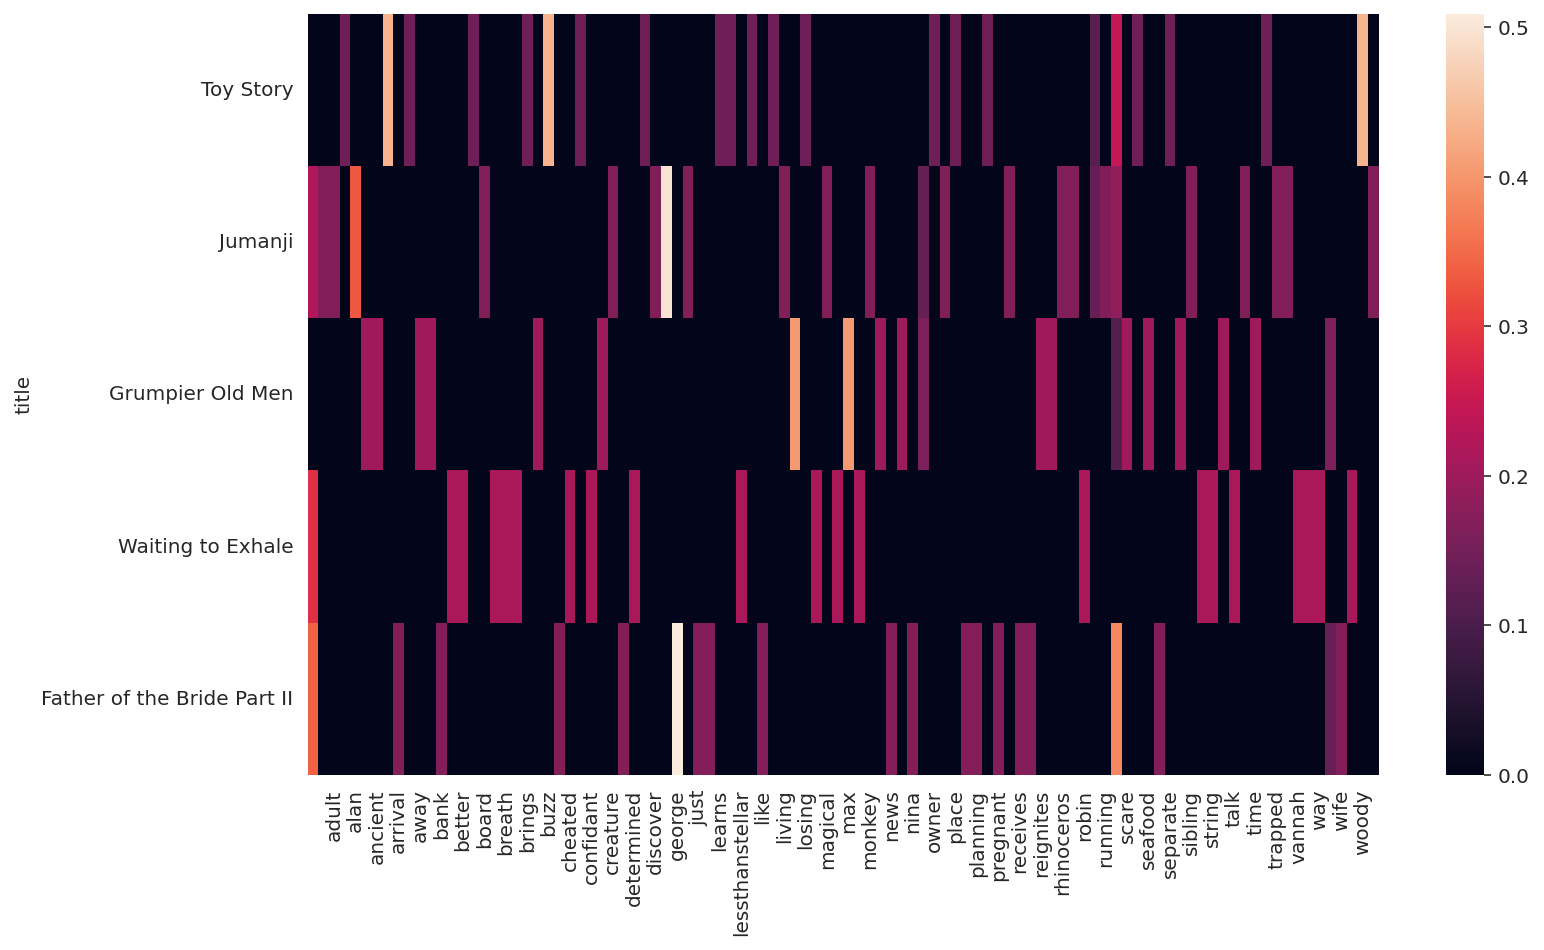

In [26]:
ax = sns.heatmap(pd.DataFrame(tfidf_matrix.todense(), index=snip['title'], columns=feature_names))

### Computing Cosine Similarity
Visually looking for similarities doesn't really work well for very many items. Instead, let's determine how similar each movie is to each other movie mathematically. We'll use cosine similarity to do that. Cosine similarity compares the direction of vectors in multi-dimensional space. The less angle between each vector, the higher the cosine-similarity score. What now? Yep, it's a lot to wrap your head around. Just remember that each row of our matrix can be thought of as a vector that can be plotted in multi-dimensional space. It's easier if we think about a 2 dimensional problem. Let's say we had 2 characteristics and 4 movies that we've scored based on those characteristics. If we plot those on a graph and draw a line from the origin (0,0) through their score points, we'd have a vector for each of the characteristics pointing in specific directions. Let's look at an example.

In [0]:
V = np.array([[12,1], [4,1], [4,7], [-12,-1]])
origin = np.array([[0, 0, 0, 0],[0, 0, 0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g','black'], scale=31)
plt.ylabel('Action')
plt.xlabel('Comedy')
plt.title('Movies rated as Action or Comedy')
plt.show()



If we imagine here the the X axis represents "Comedy" and the Y axis represents "Action", our green arrow might represent a movie that is action-packed and a little bit funny. Our red arrow might be something with just a little action and a lot of comedy. Our blue movie is somewhere right in between. Our black arrow is the exact opposite of our red arrow, and probably represents a slow-moving, serious movie. 

When we quantify this with cosine similarity, we end up with a number for each pair of movies that's somewhere between -1 (total opposites) and 1 (exactly the same). Let's look at the cosine similiarity between some of our paris of movies.

In [0]:
print('Remember - the higher the number, the closer the vectors.')
print(f'The similarity between the red and blue vectors is {round(1 - distance.cosine(V[0], V[1]), 3)}')
print(f'The similarity between the blue and green vectors is {round(1 - distance.cosine(V[1], V[2]), 3)}')
print(f'The similarity between the red and green vectors is {round(1 - distance.cosine(V[0], V[2]), 3)}')
print(f'The similarity between the red and black vectors is {round(1 - distance.cosine(V[0], V[3]), 3)}')


Of note here is the the *length* of the vector doesn't matter when we're dealing with cosine similarity - only the angle between the two vectors matters. So, our red and blue movies score nearly a perfect match, even though the red movie is arguably a more comedic movie than the blue movie. That's just how these similarity measures work.

### Dot Product (linear_kernel) vs. Cosine Similarity

Banik briefly mentions this, but it bears repeating. If you have data that's already normalized so that all the scores share the same magnitude, such as what happens with TfidfVectorizer (where each score is between 0 and 1), you can use the computationally cheaper dot product calculation using linear_kernel(). If you're using the CountVectorizer, you have to use the cosine similarity function - cosine_similarity() -  which will normalize your data before calculating your vector distances.  e

If you want to dive into the math of all this, the book "Practical Recommender Systems" by Kim Falk does a nice job of explaining and diving much deeper into these concepts.

With our snip dataset, we've constructed our vector matrix using Tfidf, so we can use the linear_kernel()/dot product method to get our similiarity scores.



In [0]:
# Compute the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

#let's look at what we've got.
dpdf = pd.DataFrame(sim_matrix, columns=snip['title'], index=snip['title'])
cm = sns.color_palette("Blues", as_cmap=True)
dpdf.style.set_caption('Dot Product with most similar movies highlighted.')\
    .background_gradient(cmap=cm)

Note that what we get is a matrix (which we've converted to a colored dataframe for display) that scores each movie in relation to another movie. A movie scored with itself will always be a one. Note that in our dataset here, Waiting to Exhale and Grumpier Old Men are our least similar two movies. Does that track with what you see in the heatmap above? Does that track with what you know of those two movies?

Which two movies are most similar?

## Using the Similarity Matrix
Now that we have this matrix, we need to be able to use it to identify similar movies. Let's break down some of what Banik does.

### Getting Index from Title
Banik uses a reverse mapping of indexes and titles to fetch data from the cosine similarity matrix. Let's take a look at what that is doing.

In [0]:
#create the reverse mapping
indices = pd.Series(snip.index, index=snip['title']).drop_duplicates()
#print it 
print(f'The index series looks like this: \n{indices}')

#if I wanted to get the index from the title I would do this:
print(f'The index for Waiting to Exhale is: {indices["Waiting to Exhale"]}')
      


Let's also break down what's going on with converting our cosine similarity to a list of tuples. 

The first thing we're doing is getting the row from the matrix that corresponds to the movie we want to review. Let's say we want to review Grumpier Old Men. Let's use the reverse mapping to get the index, and then fetch that row from our matrix.

In [0]:
idx = indices["Grumpier Old Men"]
sim_matrix[idx]

The <a href="https://book.pythontips.com/en/latest/enumerate.html">enumerate function</a> loops over some iterable object and returns a counter and the value for each item in the iterable. We can see that what cosine_sim[2] returns is an array, which is an iterable object. We can't directly print the results from enumerate, so we have to wrap it in a list function.

What this results in is a list of tuples that correspond to the column number and the cosine similarity score for each movie that we compared to Grumpier Old Men. Which column number would be Grumpier Old Men compared with itself?

In [0]:
sim_scores = list(enumerate(sim_matrix[idx]))
sim_scores

We can see that the most similar movie to Grumpier Old Men is... Grumpier Old Men. This makes sense - it's the same movie! We don't want that movie in our results, though. Since we know this is a balanced matrix (the indexes are the same for the columns and for the rows), we can just delete the item with our Grumpier Old Men index. Remember, that's 2. Let's see how that works.

In [0]:
del sim_scores[idx]
sim_scores

Great. That got rid of the tuple that corresponded to the column Grumpier Old Men.

The next thing we do is to sort this list by the score (the second bit of the tuple). We're using a lambda function to do that. Let's see what we get when we sort.

In [0]:
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores

We can see that column 4 and column 1 of our matrix contain our 2 most similar movies. But, what movies are those? We need to go back to our dataframe to figure that out. Let's extract just the indices for our top 2 movies. Finally, we'll use <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html">iloc</a> to find the corresponding movie titles.

In [0]:
top_two = [i[0] for i in sim_scores[0:2]]
print(f'The top two indices are: {top_two}')

snip.iloc[top_two]

### Recommender Function

Let's wrap this up in a function. We're going to do this slightly differently than Banik did. 
* We'll avoid giving it any variable defaults (which is a good practice unless you're hard-coding the defaults).
* We'll pass in the string to identify the seed column and get the indices mapping inside the function. (The seed column is whatever column we're using to identify the item we're interested in using to recommend other items. In this case, it's a movie title. But it could be a place name, or a recipe title, or whatever, depending on our recommender.)
* We'll also pass in the number of results to return. This is hard-coded number, so we will set a default for that.
* We'll delete the passed-in movie explicitly, instead of assuming it's the first after sorting
* We'll return the whole dataframe, not just the titles

In [0]:
def content_recommender(df, seed, seedCol, sim_matrix,  topN=2): 
    #get the indices based off the seedCol
    indices = pd.Series(df.index, index=df[seedCol]).drop_duplicates()
    
    # Obtain the index of the item that matches our seed
    idx = indices[seed]
    
    # Get the pairwsie similarity scores of all items and convert to tuples
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    #delete the item that was passed in
    del sim_scores[idx]
    
    # Sort the items based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top-n most similar items.
    sim_scores = sim_scores[:topN]
    
    # Get the item indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the topN most similar items
    return df.iloc[movie_indices]

Let's test our recommender with Grumpier Old Men and our snipped dataset again.

In [0]:
content_recommender(snip, 'Grumpier Old Men', 'title', sim_matrix, 2)

## Content-Based Recommender Self Assessment

For this example we will use the TED Talks data set that you have already loaded to build a content-based recommender based on the descriptions of the talks.  This will correspond to the **plot description-based recommender**.

### *Self-Assessment: TF-IDF Vectors*

From the original TED Talks data frame that use in this lesson, create the TF-IDF (term frequency - inverse document frequency) matrix from the descriptions of the talks.  The TF-IDF is high where a rare term is present or frequent in a document and TF-IDF is near zero where a term is absent from a document, or abundant across all documents.

The feature name in the data frame is **description**.

Preprocess the description column by using lower case letters, removing punctuation, removing the default English stop words, and using only bigrams.

Output the shape of the TF-IDF matrix you create. The number of rows corresponds to the number of TED talks in the data frame and the number of columns represents the number of unique terms. 

In [0]:
# enter your code here

### *Self-Assessment: Create the Content-Based Recommender Based on Dot Product*

Compute the dot product score for all of the TED talks in the data frame. Next build the recommender to request the name of a TED talk in the data frame and provide the top 5 recommended talks based on the similarity of the descriptions with the name of the talk supplied.

Show that it works by getting the top 5 recommended talks that are similar to the talk named "Tyler Cowen: Be suspicious of simple stories" (from the **name** column of the data frame).

In [0]:
# enter your code here

# Content-Based Recommender using MetaData

We mentioned at the beginning that you could use any text you have available. But so far, we've only demonstrated using free-form text - like a description, synopsis, or overview. You can also use metadata that comes from more defined and finite lists. Banik demonstrates this with keywords and credits and we have that code for you in the Content Based Recommenders file in this directory. 

There are some things consider when using the metadata to generate your list of features. First, if you have multiple metadata fields, you'll probably want to combine them. Banik calls this combined list of words the "soup." I think he's thinking of alphabet soup here, since we're throwing all the words together and stirring them up. That might be fine if each of your categorical lists of words are single words. But if you have categories that include phrases, you should consider pre-processing the phrases in such a way that the spaces between your words in the phrases are removed. For instance, remembering what you've learned so far, think about what would happen if you had the following records:

| Business      | Keywords                 |
| ------------- | ------------------------ |
| McDonald's    | Fast Food, High Volume   |
| MJ's Finest   | High Prices, Upscale |
| Panera        | Fast Casual              |

If we were to vectorize the keywords as-is, we'd end up with the following words: fast, food, high, volume, prices, upscale, casual. But we'd lose the differentiation between high-volume and high-prices and fast-food and fast-casual. Banik uses "sanitizing" to prevent this kind of ambiguity. The sanitizing function is available in the book and in the Content Recommender chapter notebook.

We can also demonstrate the basic principles with our snip dataset. We already have our genres in a list and none of our snip movies have more than 3 genres and each of our genres are only 1 word. So we don't have to generate lists or sanitize anything. We simply need to create a soup of our overview and our genres.

Note: genres is a list, so we'll need to use ' '.join() to turn it into a string. Overview is a string, so we just need to add that string onto the end of the string created after ' '.join()ing the genres. Be sure to add a space in between.

In [0]:
#reminder again - what's in snip
snip = snip.copy()
display(snip)

#Function that creates a soup out of the desired metadata
def create_soup(x):
    return ' '.join(x['genres']) + ' ' + x['overview'] 

#create a column with the soup in it    
snip['soup'] = snip.apply(create_soup, axis=1)   


print(f'The soup for Toy Story is: \n{snip["soup"][0]}')

Banik used a count vectorizer instead of a tf-idf vectorizer for his metadata recommender. He does this because using a tf-idf would downweight actors that appear in more than one movie. The same thing would happen with genres. So we'll follow suit and use the count vectorizer here. We'll remove stopwords and convert to lowercase and remove punctuation, but we won't use n-grams or lemmatization here.

You can read <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">the documentation for count_vectorizer</a> to learn more about it.

In [0]:

count = CountVectorizer(stop_words='english', lowercase=True)
count_matrix = count.fit_transform(snip['soup'])

#Compute the cosine similarity score 
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)


#call our same function, using the same movie. 
content_recommender(snip, 'Grumpier Old Men', 'title', cosine_sim2, topN=2)

Even with this tiny dataset, switching between TF-IDF and CountVectorizer and the linear kernel and the cosine-similarity changed our top two results.

It's worth trying different approaches with your data to determine the right fit.

## *Self-Assessment: Metadata Recommender*

Using the Ted Talks data, create a content recommender using the "ratings" and "tags" columns as your features. These columns include multi-word phrases, so use Banik's sanitize function on those two columns. Use a count vectorizer, removing English stop words and converting to lowercase, to create your vectorized matrix. Use cosine_similarity to compute your similarity matrix. Return the top 5 talks most closely related to the **title** "Humble plants that hide surprising secrets."
